<a href="https://colab.research.google.com/github/Mattshanevdberg/ML-FruitPunchAI_BootCamp/blob/main/5_2_Transfer_learning_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

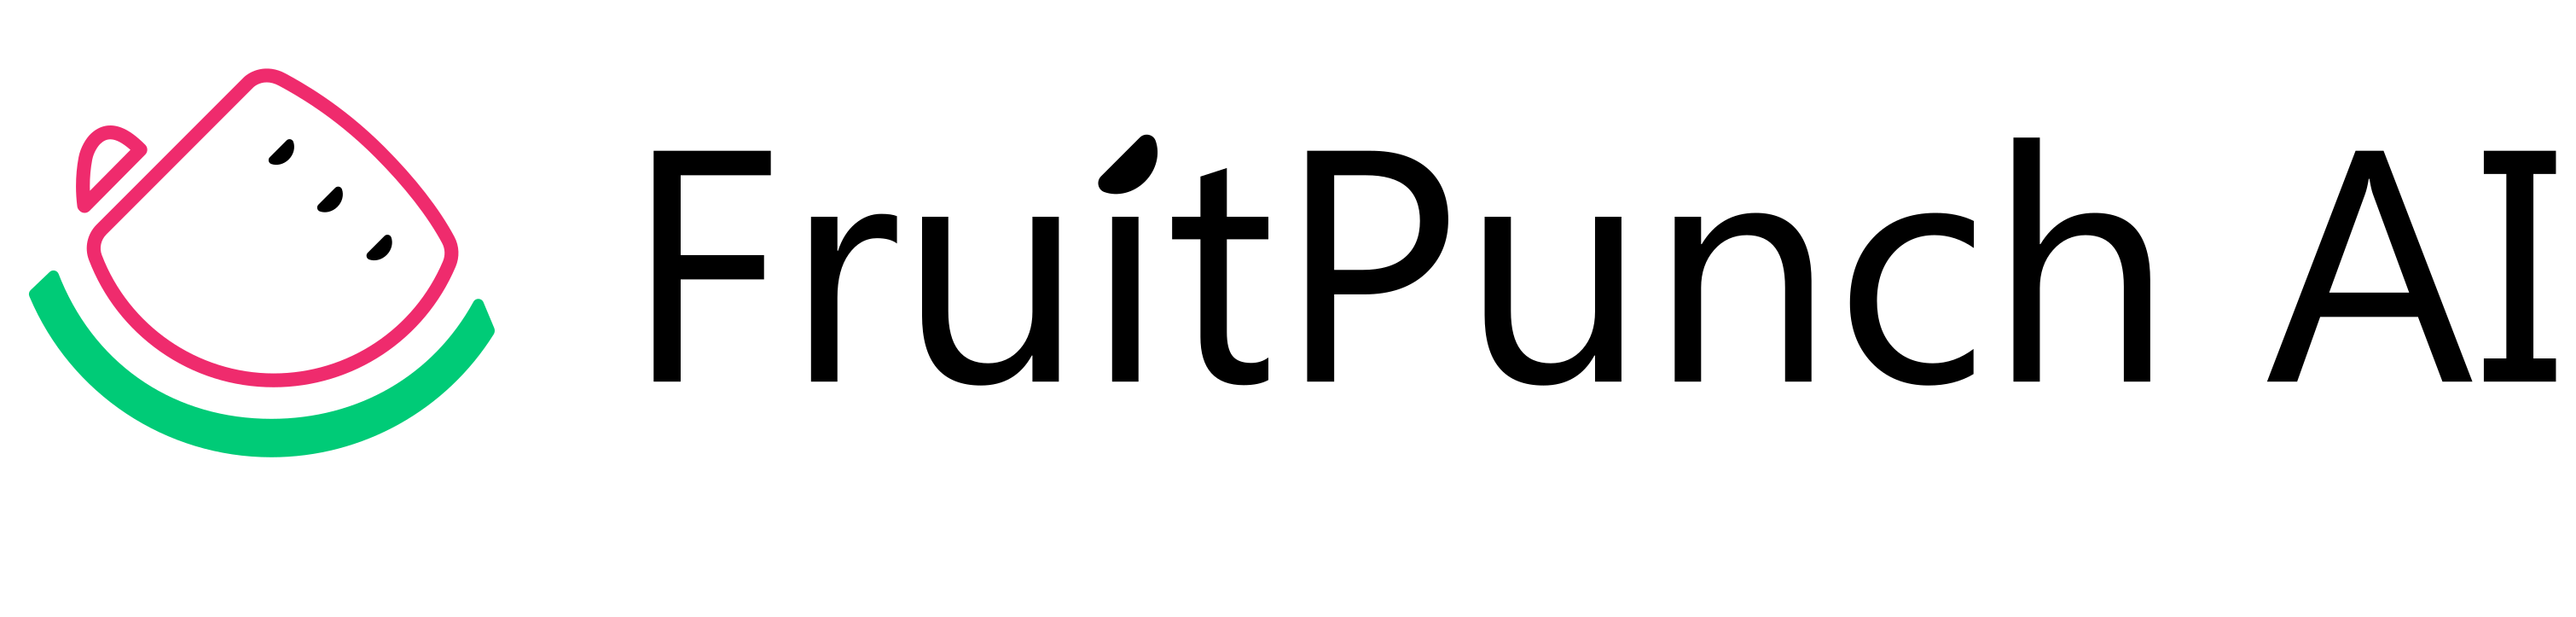

In [1]:
!pip install transformers -q

     |████████████████████████████████| 5.8 MB 32.4 MB/s 
     |████████████████████████████████| 7.6 MB 65.0 MB/s 
     |████████████████████████████████| 182 kB 77.5 MB/s 


# **Transfer Learning part 1**

First we will have a look at the huggingface library. This is a library full of large pretrained models that are easily to be installed and used. Huggingface has a large amount of NLP (Natural Language Processing) algorithms but also offers alorithms for audio and vision processing. Check out their site for all the available models:
https://huggingface.co/models

Here below we give an example of an algorithm named "bert-base-NER". bert-base-NER is a fine-tuned BERT model that is ready to use for Named Entity Recognition and achieves state-of-the-art performance for the NER task (Named Entity Recognition). It has been trained to recognize four types of entities: location (LOC), organizations (ORG), person (PER) and Miscellaneous (MISC).

For more info on named entity recognition you can check out this paper https://aclanthology.org/W03-0419.pdf

In [6]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "I'm Batman from Gotham city and I work at night."

ner_results = nlp(example)
print(ner_results)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

[{'entity': 'B-MISC', 'score': 0.6150824, 'index': 4, 'word': 'Batman', 'start': 4, 'end': 10}, {'entity': 'B-LOC', 'score': 0.99869883, 'index': 6, 'word': 'Gotham', 'start': 16, 'end': 22}]


In [3]:
ner_results = nlp('I live in South Africa')
print(ner_results)

[{'entity': 'B-LOC', 'score': 0.9996625, 'index': 4, 'word': 'South', 'start': 10, 'end': 15}, {'entity': 'I-LOC', 'score': 0.999038, 'index': 5, 'word': 'Africa', 'start': 16, 'end': 22}]


Before we really start transfer learning we want to show you how usefull pre-trained models can be, and potentially can save you a lot of time. For the first exercise we'll take a model from huggingface and see how well it performs vs our own build model from scratch. Please note: This is not yet transfer learning because we are not re-training a model.

In [2]:
# Load the dataset
!git clone https://github.com/fruitpunch-ai-code/epoch-14.git

Cloning into 'epoch-14'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [3]:
#required libraries
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import model_selection
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
#Set Random seed
np.random.seed(500)

df = pd.read_csv('/content/epoch-14/Challenges/reviews.csv', encoding='latin-1')
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


Now we will train a NLP from scratch to recognise the sentiment in amazon reviews. The model will have to determine if the review is positive or negative. 


In [52]:
# Step 1: Data Pre-processing - This will help in getting better results through the classification algorithms
Corpus = df.copy()
# Step 1a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)

# Step - 1b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [entry.lower() for entry in Corpus['text']]

# Step - 1c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]

# Step - 1d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

# Step 2: Split the model into Train and Test Data set
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=0.3)

# Step 3: Label encode the target variable  - This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

# Step 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comparison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [31]:
# print(Train_X[1])
# # print(Train_Y[0:10])
# # print(Corpus.head())
print(Train_X_Tfidf.shape, Train_X_Tfidf.dtype)
# print(Train_X.shape)
# print(Train_X_Tfidf[1])
#print(Train_Y[0:50])

(7000, 5000) float64


In [7]:
# Step 5: Now run ML algorithm to classify the text

# Classifier - Algorithm - Naive Bayes
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Classifier - Algorithm - SVM
from sklearn import svm
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

# Classifier - Algorithm - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# fit the training dataset on the classifier
clf = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=0)
clf.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_clf = clf.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Random Forest Classifier Accuracy Score -> ",accuracy_score(predictions_clf, Test_Y)*100)

# Classifier - Algorithm - AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
# fit the training dataset on the classifier
adaclf = AdaBoostClassifier(n_estimators=800, random_state=0)
adaclf.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_adaclf = adaclf.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("AdaBoost Classifier Accuracy Score -> ",accuracy_score(predictions_adaclf, Test_Y)*100)

# Classifier - Algorithm - Linear SVC
from sklearn.svm import LinearSVC
# fit the training dataset on the classifier
svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_svc = svc.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Linear SVC Accuracy Score -> ",accuracy_score(predictions_svc, Test_Y)*100)

# Classifier - Algorithm - Logistic Regression
from sklearn.linear_model import LogisticRegression
# fit the training dataset on the classifier
lr = LogisticRegression()
lr.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_lr = lr.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(predictions_lr, Test_Y)*100)

# Classifier - Algorithm - MLP Classifier
from sklearn.neural_network import MLPClassifier
# fit the training dataset on the classifier
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
mlp.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_nn = mlp.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("MLPClassifier Accuracy Score -> ",accuracy_score(predictions_nn, Test_Y)*100)

Naive Bayes Accuracy Score ->  83.26666666666667
SVM Accuracy Score ->  84.53333333333333
Random Forest Classifier Accuracy Score ->  81.16666666666667
AdaBoost Classifier Accuracy Score ->  79.60000000000001
Linear SVC Accuracy Score ->  84.06666666666666
Logistic Regression Accuracy Score ->  85.03333333333333
MLPClassifier Accuracy Score ->  81.76666666666667


The best model reaches an accuracy of 85% let's see if we can top that with a model from huggingface

### **Assignment 1**

A) Search the huggingface library for a model that can classify the reviews in this dataset on positive or negative. And run it on the data.

B) Eveluate your transfered model. Does it outperform the models build from scratch?

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForQuestionAnswering, pipeline

tokenizer2 = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")

model2 = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
model2 = "LiYuan/amazon-review-sentiment-analysis"
Corpus2 = df.copy()
Corpus2['text'][0:10]
#output = model.predict(Corpus2['text'])

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/670M [00:00<?, ?B/s]

0     Stuning even for the non-gamer: This sound tr...
1     The best soundtrack ever to anything.: I'm re...
2     Amazing!: This soundtrack is my favorite musi...
3     Excellent Soundtrack: I truly like this sound...
4     Remember, Pull Your Jaw Off The Floor After H...
5     an absolute masterpiece: I am quite sure any ...
6     Buyer beware: This is a self-published book, ...
7     Glorious story: I loved Whisper of the wicked...
8     A FIVE STAR BOOK: I just finished reading Whi...
9     Whispers of the Wicked Saints: This was a eas...
Name: text, dtype: object

In [10]:
model2 = "LiYuan/amazon-review-sentiment-analysis"

In [5]:
nlp2 = pipeline(model=model2, tokenizer=model2)#, tokenizer=tag)


In [6]:
def binary_score(outputscore):
  if outputscore >= 3:
    outputscore = 1
  else:
    outputscore = 0
  return outputscore

In [24]:
def binary_score_corpus(outputscore):
  if outputscore == '__label__2 ':
    outputscore = 1
  else:
    outputscore = 0
  return outputscore

In [8]:
# Step 2: Split the model into Train and Test Data set
Train_X2, Test_X2, Train_Y2, Test_Y2 = model_selection.train_test_split(Corpus2['text'],Corpus2['label'],test_size=0.3)

In [20]:
print(Test_X2)
print(Test_Y2)
print(Test_Y2[3])

5503     This machine makes as much noise as a power t...
6376     Less substance than a Cugel novel.: Come on p...
3861     Not their best outting: I am going to have to...
1308     Florida birds: I love my nature guide to Flor...
6380     Better than I remembered it!: Read the John C...
                              ...                        
2585     Unbelievable!: I am amazed at the high rating...
5065     expensive but well worth it.: These card hold...
7110     Impressive: I was greatly impressed by this b...
6197     awesome reading: This book is the start of an...
4730     JUNK - don't waste your money or time!: My co...
Name: text, Length: 3000, dtype: object
5503    __label__1 
6376    __label__1 
3861    __label__1 
1308    __label__2 
6380    __label__2 
           ...     
2585    __label__1 
5065    __label__2 
7110    __label__2 
6197    __label__2 
4730    __label__1 
Name: label, Length: 3000, dtype: object


KeyError: ignored

In [25]:
list_of_reviews = list(Test_X2)
short_list_of_reviews = list_of_reviews[0:10]
list_Test_Y2 = list(Test_Y2)

list_of_outcome = []
for outcome_label in list_Test_Y2:
  outcome_binary = binary_score_corpus(outcome_label)
  list_of_outcome.append(outcome_binary)

print("shape outcome:", len(list_of_outcome))
print(list_of_outcome)
print("shape outcome:", len(list_of_reviews))
print(list_of_reviews)

shape outcome: 3000
[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1

In [26]:
# To speed things up a little bit grab a subset of the data - didnt have this originally
import tensorflow as tf
with tf.device('/device:GPU:0'):
  nlp_outputlist = nlp2(list_of_reviews)

KeyboardInterrupt: ignored

In [65]:
nlp_outputlist = nlp2(list_of_reviews)
print(nlp_outputlist)

[{'label': '1 star', 'score': 0.30171531438827515}, {'label': '5 stars', 'score': 0.867158055305481}, {'label': '4 stars', 'score': 0.5122941732406616}, {'label': '5 stars', 'score': 0.9808332920074463}, {'label': '1 star', 'score': 0.6962141990661621}, {'label': '5 stars', 'score': 0.8073568344116211}, {'label': '2 stars', 'score': 0.3711637258529663}, {'label': '2 stars', 'score': 0.2670399844646454}, {'label': '5 stars', 'score': 0.9171761870384216}, {'label': '1 star', 'score': 0.8779633641242981}, {'label': '5 stars', 'score': 0.8323230743408203}, {'label': '1 star', 'score': 0.7230677604675293}, {'label': '3 stars', 'score': 0.3281083106994629}, {'label': '5 stars', 'score': 0.9465057849884033}, {'label': '5 stars', 'score': 0.6294800043106079}, {'label': '5 stars', 'score': 0.7483837604522705}, {'label': '1 star', 'score': 0.9488817453384399}, {'label': '5 stars', 'score': 0.7229325771331787}, {'label': '1 star', 'score': 0.8133558034896851}, {'label': '1 star', 'score': 0.78810

In [19]:
binary_output_score_list = []
for ind in nlp_outputlist:
  #print(ind)
  npl_outputscore_1_5 = int(ind['label'][0])
  #outputscore2 = int(outputscore[0])
  # print(Corpus2['text'][ind])
  # print(output)
  # print(outputscore)
  output_score_binary = binary_score(npl_outputscore_1_5)

  binary_output_score_list.append(output_score_binary)

print(binary_output_score_list)
print(list_of_outcome)

[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 

In [18]:
print(list_of_reviews[0:10])
print()

[' This machine makes as much noise as a power tool: All the features are nice, TV Guide worked (note that browsing and setting recording preferences is very SLOW), BUT when the TV Guide is downloading (all the time) or you are recording / playing from the hard drive you constantly hear a grinding sound from the hard drive. These guys must have used a cheap hard drive or something. I have the Amazon return slip on my desk......', " Less substance than a Cugel novel.: Come on people! Even Jack Vance's zany Dying Earth novels (Cugel in particular) have more substance than this lackadaisical tour-de-force. Skip out on Burroughs, if you want quality sci-fi read the Demon Princes by Jack Vance...", " Not their best outting: I am going to have to disagree with most of the other reviews posted here. This is not the best that Stereolab has to offer. The first Stereolab records I heard were Dots & Loops and Cobra and Phase... I was absolutely blown away by those albums. I just couldn't get that

In [27]:
from sklearn.metrics import accuracy_score
print("other classifier Accuracy Score -> ",accuracy_score(binary_output_score_list, list_of_outcome)*100)

other classifier Accuracy Score ->  89.33333333333333


In [ ]:
#oh... Thats not very good actually...